In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/dataset/train.tsv',sep='\t')

In [ ]:
data.drop(columns=['urlid','avglinksize','numwords_in_url','frameTagRatio','framebased'],inplace=True)

In [ ]:
list2=data['boilerplate'].to_list()

In [ ]:
j=0
k=0
list3=[]
for i in  list2:
  if 'null' in i:
    list3.append(k)
    
    j+=1
  k+=1
print(j)


107


In [ ]:
data.drop(data.index[list3],inplace=True)
data.reset_index(inplace=True)

In [ ]:
numerical_data=['non_markup_alphanum_characters','numberOfLinks','linkwordscore']

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [ ]:
def encode(data1):
  for column in data.columns:
    if column in numerical_data:
      data[column]=min_max_scaler.fit_transform(data[[column]])

In [ ]:
encode(data)

In [ ]:
data['news_front_page']=data['news_front_page'].replace('?',np.nan).ffill(axis=0)

In [ ]:
data['alchemy_category']=data['alchemy_category'].replace('?',np.nan).ffill(axis=0)

In [ ]:
data['alchemy_category']=data['alchemy_category'].replace({'recreation':1,'arts_entertainment':2,'business':3,'health':4,'sports':5,'culture_politics':6,'computer_internet':7,'science_technology':8,'gaming':9,'religion':10,'law_crime':11,'unknown':12,'weather':13})

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data[['alchemy_category']])
nn=enc.transform(data[['alchemy_category']]).toarray()

In [ ]:
data.drop(columns='alchemy_category',inplace=True)

In [ ]:
data['alchemy_category_score']=data['alchemy_category_score'].replace('?',np.nan).ffill(axis=0)
data['alchemy_category_score']=data['alchemy_category_score'].astype(float)

In [ ]:
data['is_news']=data['is_news'].replace('?',np.nan).ffill(axis=0)
data['is_news']=data['is_news'].astype(int)

In [ ]:
list2=data['boilerplate'].to_list()

In [ ]:
title=[]
body=[]
url=[]
for i in list2:
  ss=eval(i)
  if ss.get('title'):
    title.append(ss['title'])
  else:
    title.append('')
  if ss.get('body'):
    body.append(ss['body'])
  else:
    body.append('')
  if ss.get('url'):
    url.append(ss['url'])
  else:
    url.append('')  
  

In [ ]:
data.drop(columns=['url','boilerplate'],inplace=True)
labels=data['label']
data.drop(columns='label',inplace=True)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(title)
sequences=tokenizer.texts_to_sequences(title)
word_index=tokenizer.word_index
title_data=pad_sequences(sequences,maxlen=64,padding='post')

In [ ]:
tokenizer1=Tokenizer(num_words=30000)
tokenizer.fit_on_texts(body)
sequences2=tokenizer.texts_to_sequences(body)
word_index1=tokenizer.word_index
body_data=pad_sequences(sequences2,maxlen=256,padding='post')

In [ ]:
def modell():
  inputs=[tf.keras.layers.Input(name="onee",shape=(13,),dtype=tf.float64),tf.keras.layers.Input(name="seq",shape=(64,),dtype=tf.float64),tf.keras.layers.Input(name="seq2",shape=(256,),dtype=tf.float64),tf.keras.layers.Input(name="numeric",shape=(19,))]
  x1=tf.keras.layers.Dense(128,activation='relu')(inputs[0])
  x2=tf.keras.layers.Dense(64,activation='sigmoid')(x1)
  x3=tf.keras.layers.Embedding(10001, 256)(inputs[1])
  x4=tf.keras.layers.LSTM(256,return_sequences=True)(x3)
  x4=tf.keras.layers.Flatten()(x4)
  x5=tf.keras.layers.Dense(64,activation='relu')(x4)
  x6=tf.keras.layers.Embedding(30001,256)(inputs[2])
  x7=tf.keras.layers.LSTM(256)(x6)
  x8=tf.keras.layers.Dense(64,activation='relu')(x7)
  x9=tf.keras.layers.Dense(256,activation='relu')(inputs[3])
  x10=tf.keras.layers.Dense(128,activation='relu')(x9)
  x11=tf.keras.layers.Dense(64,activation='sigmoid')(x10)
  features=tf.keras.layers.concatenate([x2,x5,x8,x11])
  x12=tf.keras.layers.Dense(128,activation='relu')(features)
  x13=tf.keras.layers.Dense(1,activation='softmax')(x12)
  model=tf.keras.Model(inputs=inputs,outputs=x13)
  return model

In [ ]:
model=modell()

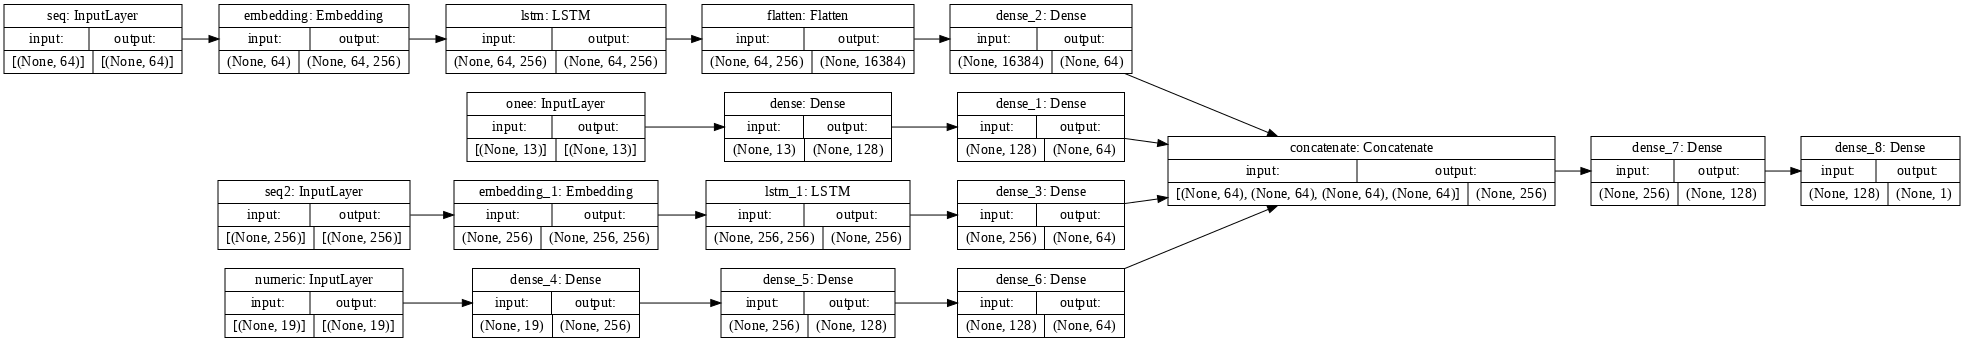

In [ ]:
tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
nn

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
title_data

array([[2159, 2567, 4344, ...,    0,    0,    0],
       [   1, 2161, 1242, ...,    0,    0,    0],
       [ 695,   33,  468, ...,    0,    0,    0],
       ...,
       [  92,  201,   86, ...,    0,    0,    0],
       [2282, 6244,    0, ...,    0,    0,    0],
       [2487, 2488,   28, ...,    0,    0,    0]], dtype=int32)

In [ ]:
body_data

array([[ 683, 3364,   11, ...,  158, 4178,  597],
       [5810, 8753,    1, ...,  750,  806, 8199],
       [ 960,    1,   89, ...,    0,    0,    0],
       ...,
       [  39,   88, 2554, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 199,   11,    3, ...,    0,    0,    0]], dtype=int32)

In [ ]:
new_data=data.values.astype('float32')

In [ ]:
new_data

array([[0.0000000e+00, 7.8913099e-01, 6.7647058e-01, ..., 3.3827063e-02,
        1.5294118e-01, 7.9129577e-02],
       [1.0000000e+00, 5.7414699e-01, 5.0802141e-01, ..., 3.7229784e-02,
        1.8181819e-01, 1.2544803e-01],
       [2.0000000e+00, 9.9652600e-01, 5.6201553e-01, ..., 5.1441152e-02,
        1.6666667e-01, 5.7613168e-02],
       ...,
       [7.3920000e+03, 1.9627300e-01, 3.1578946e-01, ..., 1.5012010e-02,
        4.3421054e-01, 1.1764706e-01],
       [7.3930000e+03, 6.1787599e-01, 2.1052632e-01, ..., 7.4059246e-03,
        2.6315790e-02, 3.3333334e-01],
       [7.3940000e+03, 6.1787599e-01, 5.0591713e-01, ..., 6.7453966e-02,
        5.9171598e-03, 1.3414635e-01]], dtype=float32)

In [ ]:
list1=[1,2,3,4,5]
list1[:-1]

[1, 2, 3, 4]

In [ ]:
new_data[:,:-1]

array([[0.0000000e+00, 7.8913099e-01, 6.7647058e-01, ..., 2.6082942e-02,
        3.3827063e-02, 1.5294118e-01],
       [1.0000000e+00, 5.7414699e-01, 5.0802141e-01, ..., 2.3914173e-02,
        3.7229784e-02, 1.8181819e-01],
       [2.0000000e+00, 9.9652600e-01, 5.6201553e-01, ..., 1.0771717e-02,
        5.1441152e-02, 1.6666667e-01],
       ...,
       [7.3920000e+03, 1.9627300e-01, 3.1578946e-01, ..., 4.0778643e-03,
        1.5012010e-02, 4.3421054e-01],
       [7.3930000e+03, 6.1787599e-01, 2.1052632e-01, ..., 1.8561976e-03,
        7.4059246e-03, 2.6315790e-02],
       [7.3940000e+03, 6.1787599e-01, 5.0591713e-01, ..., 2.4765329e-03,
        6.7453966e-02, 5.9171598e-03]], dtype=float32)

In [ ]:
model.fit([nn,title_data,body_data,new_data],labels,epochs=5)

Epoch 1/5
228/228 [==============================] - 35s 133ms/step - loss: 0.5880 - accuracy: 0.5228
Epoch 2/5
228/228 [==============================] - 30s 131ms/step - loss: 0.3185 - accuracy: 0.5032
Epoch 3/5
228/228 [==============================] - 30s 131ms/step - loss: 0.1625 - accuracy: 0.5143
Epoch 4/5
228/228 [==============================] - 30s 130ms/step - loss: 0.0885 - accuracy: 0.5087
Epoch 5/5
228/228 [==============================] - 30s 131ms/step - loss: 0.0809 - accuracy: 0.5204
